# AI model training: can a machine detect types of questions with both textual and prosodic features?
1. Load the dataset

In [24]:
import pandas as pd
import ast

import os

if os.path.exists("N_1000_filtered_train_data_with_features.csv"):
    filename = "N_1000_filtered_train_data_with_features.csv"
else:
    filename = "example_files/N_1000_filtered_train_data_with_features.csv"
# Load full dataset
df = pd.read_csv(filename)

# Define labels that are questions
question_labels = {'yn', 'wh', 'imp'}

# Sample with all columns preserved
yn_df = df[df['label'] == 'yn']
wh_df = df[df['label'] == 'wh'].sample(n=min(100, len(df[df['label'] == 'wh'])), random_state=42)
imp_df = df[df['label'] == 'imp'].sample(n=min(100, len(df[df['label'] == 'imp'])), random_state=42)
nq_df = df[df['label'] == 'nq'].sample(n=295, random_state=42)

# Combine them
balanced_df = pd.concat([yn_df, wh_df, imp_df, nq_df])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Parse MFCCs
balanced_df['mfcc_means'] = balanced_df['mfcc_means'].apply(ast.literal_eval)

# Check counts
print(balanced_df['label'].value_counts())

label
nq     295
imp    100
wh     100
yn      95
Name: count, dtype: int64


2. Organize all data to prepare for AI training (only text)

In [25]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import sparse

# Vectorize text
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(balanced_df['text'])

# Extract dense acoustic features
numeric_features = balanced_df[[
    'word_count', 'f0_mean', 'f0_std', 'f0_end_slope',
    'energy_mean', 'energy_std', 'zcr_mean'
]].values

mfcc_features = np.array(balanced_df['mfcc_means'].tolist())

# Combine numeric + MFCCs
dense_features = np.hstack([numeric_features, mfcc_features])

# Scale the dense features (insert this here!)
scaler = StandardScaler()
scaled_dense = scaler.fit_transform(dense_features)

# Convert scaled dense to sparse, and combine with text
dense_sparse = sparse.csr_matrix(scaled_dense)
X = hstack([text_features, dense_sparse])

# Labels
y = balanced_df['label']

3.1 Model training and visulization(Logistical regression)

Classification Report:
               precision    recall  f1-score   support

         imp       0.93      0.70      0.80        20
          nq       0.79      0.97      0.87        59
          wh       0.82      0.70      0.76        20
          yn       0.79      0.58      0.67        19

    accuracy                           0.81       118
   macro avg       0.83      0.74      0.77       118
weighted avg       0.82      0.81      0.81       118

Confusion Matrix:
 [[14  5  1  0]
 [ 0 57  2  0]
 [ 0  3 14  3]
 [ 1  7  0 11]]


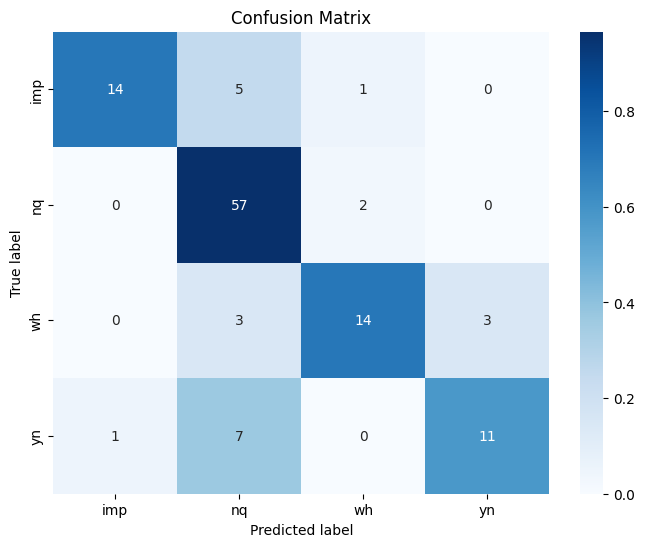

In [26]:
# Train a Classifier

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
clf = LogisticRegression(max_iter=5000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Use seaborn for visualization
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute the raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize it so each row sums to 1 (color)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,               # or cm if you want counts
    annot=cm,              # show raw counts in the boxes
    fmt='d',               # integer format for counts
    cmap='Blues',          # choose a colormap you like
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

3.2 Model training and visulization(SVM)

Classification Report:
               precision    recall  f1-score   support

         imp       0.89      0.85      0.87        20
          nq       0.93      0.95      0.94        59
          wh       0.85      0.85      0.85        20
          yn       0.84      0.84      0.84        19

    accuracy                           0.90       118
   macro avg       0.88      0.87      0.88       118
weighted avg       0.90      0.90      0.90       118

Confusion Matrix:
 [[17  2  1  0]
 [ 1 56  2  0]
 [ 0  0 17  3]
 [ 1  2  0 16]]


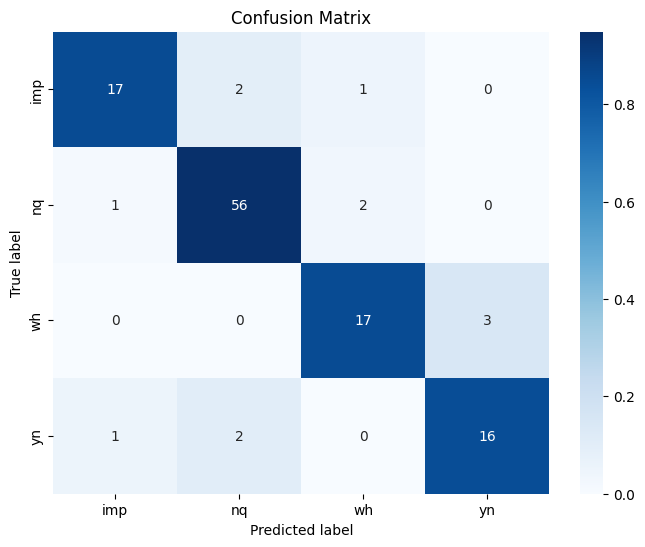

In [27]:
from sklearn.svm import LinearSVC 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=777, stratify=y
)

# Train the SVM model
clf = LinearSVC(max_iter=5000)
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


# Compute the raw confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalize it so each row sums to 1 (color)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# 3. Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,               # or cm if you want counts
    annot=cm,              # show raw counts in the boxes
    fmt='d',               # integer format for counts
    cmap='Blues',          # choose a colormap you like
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Confusion Matrix")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()


4.1 Perform a 7-fold cross validation (LogisticRegression)

Fold 1 Confusion Matrix:
[[12  1  0  1]
 [ 1 42  0  0]
 [ 0  5 10  0]
 [ 1  2  1  9]]

Fold 1 Accuracy: 0.8588
Fold 1 Recall (macro): 0.7982

Fold 2 Confusion Matrix:
[[ 8  7  0  0]
 [ 0 41  0  1]
 [ 0  3 12  0]
 [ 1  4  0  8]]

Fold 2 Accuracy: 0.8118
Fold 2 Recall (macro): 0.7312

Fold 3 Confusion Matrix:
[[ 7  7  0  1]
 [ 1 41  0  0]
 [ 1  3  9  1]
 [ 0  4  0  9]]

Fold 3 Accuracy: 0.7857
Fold 3 Recall (macro): 0.6945

Fold 4 Confusion Matrix:
[[10  4  0  0]
 [ 1 41  0  0]
 [ 2  0 10  2]
 [ 1  5  1  7]]

Fold 4 Accuracy: 0.8095
Fold 4 Recall (macro): 0.7262

Fold 5 Confusion Matrix:
[[10  4  0  0]
 [ 2 39  1  0]
 [ 2  3  7  2]
 [ 2  2  0 10]]

Fold 5 Accuracy: 0.7857
Fold 5 Recall (macro): 0.7143

Fold 6 Confusion Matrix:
[[ 8  4  1  1]
 [ 0 40  2  0]
 [ 0  2 11  1]
 [ 1  4  1  8]]

Fold 6 Accuracy: 0.7976
Fold 6 Recall (macro): 0.7202

Fold 7 Confusion Matrix:
[[11  2  1  0]
 [ 2 38  2  0]
 [ 0  3 11  0]
 [ 0  4  2  8]]

Fold 7 Accuracy: 0.8095
Fold 7 Recall (macro): 0.7619

Averag

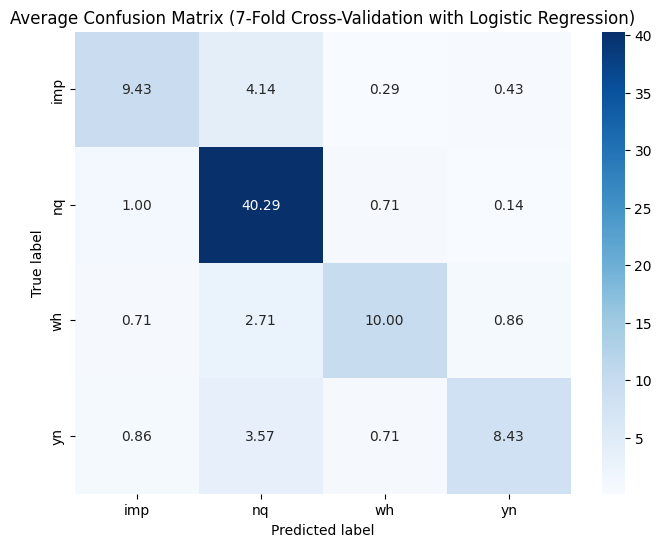

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.model_selection import StratifiedKFold

# Define the number of folds
n_splits = 7
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# Lists to store confusion matrices and metrics for each fold
conf_mats = []
accuracy_scores = []
recall_scores = []

# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Split the data into training and validation sets
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the Logistic Regression model
    clf = LogisticRegression(max_iter=5000)
    clf.fit(X_train, y_train)
    
    # Make predictions on the validation fold
    y_pred = clf.predict(X_val)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_val, y_pred)
    conf_mats.append(cm)
    
    # Compute accuracy and recall for the current fold
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred, average='macro')  # macro average computes recall for each class and takes the unweighted mean
    accuracy_scores.append(acc)
    recall_scores.append(rec)
    
    # Print fold-specific results
    print(f"Fold {fold} Confusion Matrix:\n{cm}\n")
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Recall (macro): {rec:.4f}\n")

# Compute the average confusion matrix, accuracy, and recall across all folds
avg_cm = np.mean(conf_mats, axis=0)
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)

print("Average Confusion Matrix:\n", avg_cm)
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Recall (macro): {avg_recall:.4f}")

# Plot the average confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    avg_cm, 
    annot=True, 
    fmt=".2f",  # Format floats with 2 decimal places
    cmap="Blues",
    xticklabels=clf.classes_,
    yticklabels=clf.classes_
)
plt.title("Average Confusion Matrix (7-Fold Cross-Validation with Logistic Regression)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()



4.2 Perform a 7-fold cross validation (SVM)

Fold 1 Confusion Matrix:
[[10  3  1  0]
 [ 3 38  2  0]
 [ 0  0 14  1]
 [ 0  1  0 12]]

Fold 1 Accuracy: 0.8706
Fold 1 Recall (macro): 0.8636

Fold 2 Confusion Matrix:
[[12  2  0  1]
 [ 3 39  0  0]
 [ 0  1 14  0]
 [ 2  2  0  9]]

Fold 2 Accuracy: 0.8706
Fold 2 Recall (macro): 0.8386

Fold 3 Confusion Matrix:
[[10  4  0  1]
 [ 0 40  2  0]
 [ 1  1 10  2]
 [ 0  3  1  9]]

Fold 3 Accuracy: 0.8214
Fold 3 Recall (macro): 0.7564

Fold 4 Confusion Matrix:
[[11  3  0  0]
 [ 2 39  1  0]
 [ 1  0 12  1]
 [ 0  2  1 11]]

Fold 4 Accuracy: 0.8690
Fold 4 Recall (macro): 0.8393

Fold 5 Confusion Matrix:
[[11  3  0  0]
 [ 3 38  1  0]
 [ 1  4  9  0]
 [ 1  1  1 11]]

Fold 5 Accuracy: 0.8214
Fold 5 Recall (macro): 0.7798

Fold 6 Confusion Matrix:
[[11  3  0  0]
 [ 0 41  0  1]
 [ 0  2 10  2]
 [ 1  2  0 11]]

Fold 6 Accuracy: 0.8690
Fold 6 Recall (macro): 0.8155

Fold 7 Confusion Matrix:
[[13  1  0  0]
 [ 2 39  0  1]
 [ 0  2 12  0]
 [ 0  2  1 11]]

Fold 7 Accuracy: 0.8929
Fold 7 Recall (macro): 0.8750

Averag

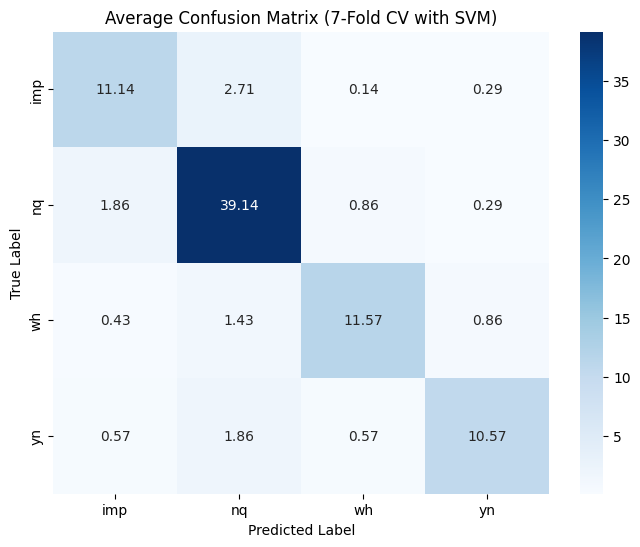

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score
from sklearn.model_selection import StratifiedKFold

# Define the number of folds for cross-validation
n_splits = 7
skf = StratifiedKFold(n_splits=n_splits, shuffle=True)

# List to store confusion matrices for each fold
conf_mats = []
accuracy_scores = []
recall_scores = []


# Iterate over each fold
for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
    # Split the data into training and validation sets.
    # Note: If X is a sparse matrix and y is a Pandas Series, we adjust indexing accordingly.
    X_train, X_val = X[train_index], X[test_index]
    y_train, y_val = y.iloc[train_index], y.iloc[test_index]
    
    # Initialize and train the SVM model. Using a linear kernel as an example.
    svm_model = SVC(kernel='linear', probability=True)
    svm_model.fit(X_train, y_train)
    
    # Make predictions on the validation fold
    y_pred = svm_model.predict(X_val)
    
    # Compute the confusion matrix for this fold and store it
    cm = confusion_matrix(y_val, y_pred)
    conf_mats.append(cm)
    
    # Compute accuracy and recall for this fold
    acc = accuracy_score(y_val, y_pred)
    rec = recall_score(y_val, y_pred, average='macro')  # Using macro-average for recall
    accuracy_scores.append(acc)
    recall_scores.append(rec)
    
    # Print fold-specific results
    print(f"Fold {fold} Confusion Matrix:\n{cm}\n")
    print(f"Fold {fold} Accuracy: {acc:.4f}")
    print(f"Fold {fold} Recall (macro): {rec:.4f}\n")

# Compute the average confusion matrix across all folds
avg_cm = np.mean(conf_mats, axis=0)
avg_accuracy = np.mean(accuracy_scores)
avg_recall = np.mean(recall_scores)

print("Average Confusion Matrix:\n", avg_cm)
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Recall (macro): {avg_recall:.4f}")

# Plot the average confusion matrix with seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(
    avg_cm, 
    annot=True, 
    fmt=".2f",  # Display floats with 2 decimal places
    cmap="Blues",
    xticklabels=svm_model.classes_,
    yticklabels=svm_model.classes_
)
plt.title("Average Confusion Matrix (7-Fold CV with SVM)")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()




## Determine if using prosodic features improves classification accuracy

In [30]:
from sklearn.model_selection import StratifiedKFold
from scipy.stats import ttest_rel

X1 = hstack([text_features, dense_sparse])
X2 = text_features

# Number of repetitions and CV folds
n_repeats = 30
n_splits = 7

acc_X1_all = []
acc_X2_all = []

for repeat in range(n_repeats):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=repeat)
    
    acc_X1 = []
    acc_X2 = []
    
    for train_index, test_index in skf.split(X1, y):
        X1_train, X1_val = X1[train_index], X1[test_index]
        X2_train, X2_val = X2[train_index], X2[test_index]
        y_train, y_val = y.iloc[train_index], y.iloc[test_index]

        # SVM on X1
        svm_X1 = SVC(kernel='linear')
        svm_X1.fit(X1_train, y_train)
        y_pred_X1 = svm_X1.predict(X1_val)
        acc_X1.append(accuracy_score(y_val, y_pred_X1))

        # SVM on X2
        svm_X2 = SVC(kernel='linear')
        svm_X2.fit(X2_train, y_train)
        y_pred_X2 = svm_X2.predict(X2_val)
        acc_X2.append(accuracy_score(y_val, y_pred_X2))
    
    acc_X1_all.extend(acc_X1)
    acc_X2_all.extend(acc_X2)

# Convert to numpy arrays
acc_X1_all = np.array(acc_X1_all)
acc_X2_all = np.array(acc_X2_all)

plt.hist(acc_X1_all, bins=30, alpha=0.5, label='X1', color='red')
plt.hist(acc_X2_all, bins=30, alpha=0.5, label='X2', color='green')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Accuracy Distribution for X1 and X2')
plt.legend()
plt.show()

# Paired t-test
t_stat, p_val = ttest_rel(acc_X1_all, acc_X2_all)
print(f"Paired t-test over {n_repeats * n_splits} evaluations:")
print(f"  t = {t_stat:.4f}, p = {p_val:.10f}")
print(f"  Mean Acc X1 = {acc_X1_all.mean():.4f}, X2 = {acc_X2_all.mean():.4f}")


KeyboardInterrupt: 